In [1]:
%matplotlib inline

import pickle

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.collections import PathCollection
from tqdm import tqdm

from atlas_general import load_atlas

In [2]:
try:
    # Load in distances
    distances = np.load("data/atlas_dist/distances.npy")
    dists_real = distances[:, 0].tolist()
    dists_atlas = distances[:, 1].tolist()
except FileNotFoundError:
    # Load in points and graph
    X = np.load("data/klein_dist/carlsson_points.npy")
    G = pickle.load(open("data/klein_dist/carlsson_graph.pkl", "rb"))

    # Generate atlas graph
    ka = load_atlas("random_klein", 2, 9)

    # Generate dense subgraph
    ka.construct_dense_graph()
    
    # Randomly select points from graph
    np.random.seed(493)
    N, _ = X.shape

    n_pairs = 100

    inds = np.random.choice(N, size=(2*n_pairs), replace=False)
    inds_start = inds[:n_pairs]
    inds_end = inds[n_pairs:]

    dists_real = []
    dists_atlas = []
    for start, end in tqdm(zip(inds_start, inds_end), total=n_pairs):
    #for start, end in zip(inds_start, inds_end):
        # Compute real distance
        dist_real = nx.shortest_path_length(G, source=start, target=end,
                            weight="weight")

        # Compute atlas distance
        x_start = X[start, :]
        x_end = X[end, :]
        xi_0, chart_0 = ka.ingest_ambient_point(x_start)
        xi_1, chart_1 = ka.ingest_ambient_point(x_end)

        _, _, _, dist_atlas = ka.approximate_shortest_path(xi_0, chart_0,
                                                    xi_1, chart_1)
        
        # X_pair = np.stack([x_start, x_end])
        # chart_assignments = ka.assign_charts(X_pair)
        # chart_start = tuple(chart_assignments[0, :])
        # chart_end = tuple(chart_assignments[1, :])
        # L_start = ka.L_dict[chart_start]
        # L_end = ka.L_dict[chart_end]
        # center_start = ka.center_dict[chart_start]
        # center_end = ka.center_dict[chart_end]
        # xi_start = L_start.T @ (x_start - center_start)
        # xi_end = L_end.T @ (x_end - center_end)
        # _, _, _, dist_atlas = ka.approximate_shortest_path(xi_start, chart_start,
        #                       xi_end, chart_end)
        # Store distances
        dists_real.append(dist_real)
        dists_atlas.append(dist_atlas)
    dists_real_vec = np.array(dists_real)
    dists_atlas_vec = np.array(dists_atlas)
    distances = np.stack([dists_real_vec, dists_atlas_vec]).T
    assert distances.shape[1] == 2
    np.save("data/atlas_dist_naive/distances.npy", distances)

100%|████████████████████████████████████████████████████████████████████████████| 100/100 [1:02:23<00:00, 37.44s/it]


TypeError: save() missing 1 required positional argument: 'arr'

In [5]:
ratios = [(dist_atlas/dist_real) for dist_atlas, dist_real in zip(dists_atlas, dists_real)]
r_max = np.max(ratios)
r_min = np.min(ratios)
alpha = r_max / r_min

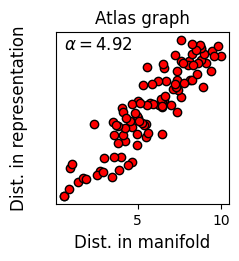

In [6]:
fig = plt.figure(figsize=(3, 3))
gs_len = 8
gs = GridSpec(gs_len, gs_len)
ax = fig.add_subplot(gs[1:-1, 1:-1])
#ax.scatter(dists_real, dists_real, color="b")
ax.scatter(dists_real, dists_atlas, color="r")
ax.set_xlabel("Dist. in manifold", fontsize=12)
ax.set_ylabel("Dist. in representation", fontsize=12, labelpad=20)
ax.set_title("Atlas graph")

ax.set_yticks([])
ax.text(0.05, 0.9, r"$\alpha="+str(alpha)[:4]+"$",
        fontsize=12, transform=ax.transAxes)

path_collections = [item for item in ax.get_children() if isinstance(item, PathCollection)]
for pc in path_collections:
    pc.set_edgecolor("k")

fig.savefig("graphics/dist/atlas_dist_naive.jpg")
    
plt.show()